In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("./survey_norm.csv")

In [2]:
from ast import literal_eval
dataset= []
for i in range(data['input_data'].size):
    dataset.append([np.array(literal_eval(data['input_data'][i].replace(' ', ',').replace(',,', ',')), dtype = float)
                     , np.array(literal_eval(data['want_hot_vec'][i].replace(' ', ',').replace(',,', ',')), dtype = int)])

In [3]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [4]:
import random
random.shuffle(dataset)

In [5]:
train_set = dataset[:-30]
test_set = dataset[-30:]

train_input = []
train_target = []

test_input = []
test_target = []
for i in range(len(train_set)):
    train_input.append(train_set[i][0].copy())
    train_target.append(train_set[i][1].copy())

train_input = np.array(train_input)
train_target = np.array(train_target)

for i in range(len(test_set)):
    test_input.append(test_set[i][0].copy())
    test_target.append(test_set[i][1].copy())

test_input = np.array(test_input)
test_target = np.array(test_target)

In [6]:
import tensorflow as tf
from keras import models 
from keras import layers
from keras import regularizers

def build_model(train_len):
    model = models.Sequential()
    model.add(layers.Dense(16, activation = 'relu', input_shape = (train_len, )))
    model.add(layers.Dense(16, activation = 'relu'))
    model.add(layers.Dense(7))
    
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
    #model.compile(optimizer = 'adam', loss='mse', metrics=['accuracy'])
    return model

In [7]:
k = 4
num_val_sample = len(train_input) // k
num_epochs = 200
all_mae_histories = []

np.random.shuffle(train_input)
for i in range(k):
    val_input = train_input[i * num_val_sample : (i+1) * num_val_sample]
    val_target = train_target[i * num_val_sample : (i+1) * num_val_sample]
    
    partial_train_input = np.concatenate(
        [train_input[:i * num_val_sample],
         train_input[(i + 1) * num_val_sample:]], axis = 0)
    partial_train_target = np.concatenate(
        [train_target[:i * num_val_sample],
         train_target[(i + 1) * num_val_sample:]], axis = 0)
    
    model = build_model(partial_train_input.shape[1])
    history = model.fit(partial_train_input, partial_train_target, 
                        validation_data = (val_input, val_target), epochs = num_epochs, 
              batch_size = 4, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

In [8]:
average_mae_history = [np.mean([x[i] for  x in all_mae_histories]) for i in range(num_epochs)]

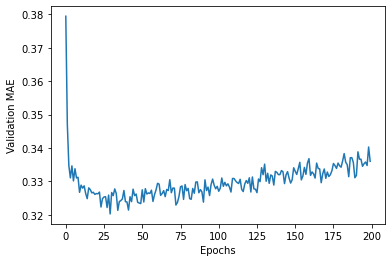

In [9]:
import matplotlib.pyplot as plt

#smooth_mae_history = smooth_curve(average_mae_history[10:])

#plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.plot(range(num_epochs), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

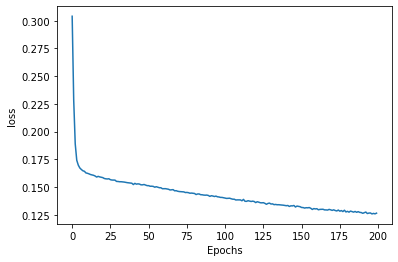

In [10]:
history_dict = history.history

plt.plot(range(num_epochs), history_dict['loss'])
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

In [51]:
model = build_model(train_input.shape[1])
model.fit(train_input, train_target, epochs = 50, batch_size = 4, verbose = 0)
test_mse, test_mae = model.evaluate(test_input, test_target)
print(test_mse, test_mae)

1/1 [==============================] - 0s 58ms/step - loss: 0.1596 - mean_absolute_error: 0.3166
0.15956951677799225 0.31662702560424805


In [52]:
result_df = pd.DataFrame(columns = ['input_data', 'target', 'result'])
pred_result = model.predict(test_input)

for i in range(pred_result.shape[0]):
    result_df.loc[i] = [test_input[i], test_target[i], pred_result[i]]


In [53]:
last_out = []
for i in range(pred_result.shape[0]):
    temp = []
    for j in range(pred_result.shape[1]):
        if pred_result[i][j] > 0.60:
            temp.append(1)
        else:
            temp.append(0)
            
    if np.all(np.array(temp) == 0):
        temp[np.argmax(np.array(temp))] = 1
        
    last_out.append(temp)
last_out = np.array(last_out)

In [54]:
collect_cnt = 0
for i in range(pred_result.shape[0]):
    for j in range(pred_result.shape[1]):
        if last_out[i][j] == test_target[i][j]:
            collect_cnt += 1

In [55]:
print((collect_cnt / 210) * 100)

76.66666666666667


In [56]:
for i in range(pred_result.shape[0]):
    print(test_input[i], ', ', test_target[i], ', ', last_out[i])

[0.8 1.  0.4 0.4 0.6 0.4 0.6 1. ] ,  [0 1 0 0 0 0 0] ,  [0 1 0 0 0 0 0]
[0.8 0.2 0.2 1.  1.  0.6 0.4 1. ] ,  [0 0 0 1 0 0 0] ,  [0 1 0 0 0 0 0]
[0.6 0.8 0.6 0.6 0.4 0.6 0.6 1. ] ,  [1 1 0 0 0 0 0] ,  [1 0 0 0 0 0 0]
[0.8 0.8 0.8 0.6 0.6 0.6 0.8 0. ] ,  [0 0 1 1 0 0 0] ,  [0 1 0 0 0 0 0]
[1.  0.6 0.2 0.4 0.8 0.4 0.8 1. ] ,  [1 0 1 0 1 0 0] ,  [0 1 0 0 0 0 0]
[1.  0.8 0.2 0.6 0.4 0.4 0.4 1. ] ,  [1 1 0 0 0 0 0] ,  [0 1 0 0 0 0 0]
[0.8 1.  0.8 0.4 0.4 0.6 0.8 1. ] ,  [0 0 1 0 0 0 0] ,  [0 1 0 0 0 0 0]
[0.8 1.  1.  0.4 0.2 0.6 0.8 1. ] ,  [0 1 1 0 0 0 0] ,  [1 0 0 0 0 0 0]
[0.8 0.8 0.6 0.4 0.4 0.8 0.8 0. ] ,  [0 1 0 0 0 0 0] ,  [0 1 0 0 0 0 0]
[0.8 0.8 0.8 0.4 0.4 0.6 0.6 1. ] ,  [0 1 0 0 0 0 0] ,  [1 0 0 0 0 0 0]
[1.  1.  0.4 0.2 0.6 0.6 0.8 1. ] ,  [1 1 0 0 0 0 0] ,  [0 1 0 0 0 0 0]
[1.  0.8 0.6 0.8 0.6 0.8 0.8 0. ] ,  [1 1 0 1 0 0 0] ,  [1 1 0 0 0 0 0]
[1.  0.6 0.2 0.8 0.4 0.4 0.4 0. ] ,  [1 0 0 0 0 0 0] ,  [0 1 0 0 0 0 0]
[1.  0.8 0.4 0.6 0.4 0.6 0.2 1. ] ,  [1 0 0 0 0 0 0] ,  [1 0 0 0

In [57]:
for i in range(train_input.shape[0]):
    print(train_input[i], train_target[i])

[0.6 0.8 0.8 0.8 0.6 0.6 0.8 1. ] [0 1 0 0 0 0 0]
[1.  0.8 0.6 0.8 0.6 0.6 0.2 0. ] [1 1 0 1 0 0 0]
[1.  0.8 0.6 1.  0.2 0.2 0.2 1. ] [0 1 0 0 0 0 0]
[1.  1.  0.8 0.8 0.6 1.  0.8 0. ] [1 1 0 0 1 0 0]
[1.  1.  1.  0.4 0.8 0.6 1.  1. ] [1 1 1 0 0 0 0]
[0.4 0.4 0.4 0.8 0.8 0.8 0.2 1. ] [1 1 0 0 0 0 0]
[0.8 0.6 0.2 0.4 0.2 0.4 0.6 1. ] [0 1 0 0 0 0 0]
[1.  0.2 0.2 0.6 1.  0.6 0.2 1. ] [0 1 0 0 0 0 1]
[0.8 1.  0.8 0.8 0.4 1.  1.  0. ] [1 0 0 0 0 0 1]
[0.8 0.8 0.6 0.8 0.4 0.8 0.8 1. ] [1 0 0 0 0 0 0]
[1.  0.6 1.  0.6 0.2 0.4 1.  1. ] [1 1 0 0 0 0 0]
[1.  0.8 0.2 0.8 0.4 0.6 0.6 1. ] [0 1 0 0 0 0 0]
[1.  1.  0.4 0.6 0.8 1.  0.8 1. ] [0 0 1 0 1 0 1]
[1.  1.  0.6 0.8 0.8 0.6 0.4 1. ] [1 1 0 0 0 0 0]
[1.  0.8 0.4 1.  0.8 0.8 0.8 1. ] [1 1 0 1 1 0 0]
[1.  0.8 0.6 1.  0.4 1.  0.8 1. ] [1 1 0 0 0 0 0]
[0.8 0.8 0.6 1.  0.6 1.  0.8 0. ] [1 0 0 0 1 0 0]
[1.  0.2 1.  0.2 0.6 0.4 0.2 1. ] [1 1 0 0 0 0 0]
[1.  0.6 0.8 0.8 0.4 0.6 0.6 1. ] [1 1 0 0 0 0 0]
[1.  0.8 0.8 0.8 0.4 0.8 0.8 0. ] [1 1 0 0 0 0 0]


In [58]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                144       
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 7)                 119       
                                                                 
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.save('TT_datamodel')

INFO:tensorflow:Assets written to: TT_datamodel\assets


In [60]:
from keras import models
new_model = models.load_model('TT_datamodel')
new_model.evaluate(test_input, test_target)

1/1 [==============================] - 0s 59ms/step - loss: 0.1596 - mean_absolute_error: 0.3166


[0.15956951677799225, 0.31662702560424805]

In [61]:
collect_cnt = 0
is_collect = True
for i in range(pred_result.shape[0]):
    is_collect = True
    for j in range(pred_result.shape[1]):
        if last_out[i][j] != test_target[i][j]:
            is_collect = False
    if is_collect:
        collect_cnt += 1